In [ ]:
import numpy as np
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
from film import FilmSimple
from spectrum import Spectrum
from design import Design

from analyze_utils.structure import plot_layer_thickness
from optimizer.adam import adam_optimize
import pickle

def make_reflection_design(init_film: FilmSimple):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500) # when wls = 50, ~100 min
    # R = np.ones(wls.shape[0] , dtype='float')
    R = np.zeros(wls.shape[0] , dtype='float')
    R[wls.shape[0] // 2:] = 1.
    target_spec = [Spectrum(inc_ang, wls, R)]
    
    design = Design(target_spec, init_film)
    return design


init_ots = np.arange(1, 10000, 1000)
layer_numbers = np.arange(1, 200, 10)
rep_number = 3

for init_ot in init_ots:
    for rep in range(rep_number):

        for layer_number in layer_numbers:
            np.random.seed(rep)
            d = np.random.random(layer_number)
            init_film = FilmSimple('SiO2', 'TiO2', 'SiO2', d)
            d *= init_ot / (init_film.get_optical_thickness(700.)) # roughly 1000 nm ot
            
            design = make_reflection_design(init_film)
            losses = adam_optimize(design.film, design.target_specs, 5000, alpha=1, show=True, record=True)
            
            fname = f'./raw_result/band_filter/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
            with open(fname, 'wb') as f:
                pickle.dump(design, f)



0.08188497010455226
1991.697019708768
2430.974257268008
17


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(<AxesSubplot: title={'center': 'refractive index distribution at  701 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

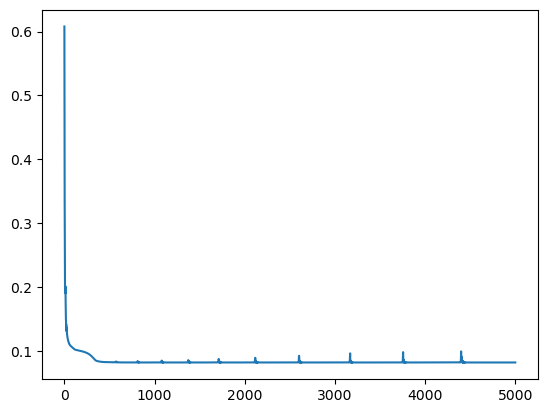

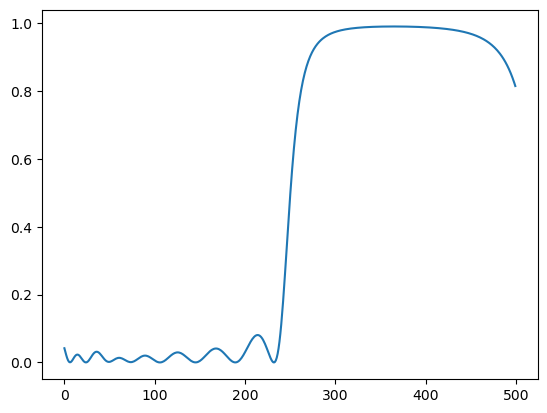

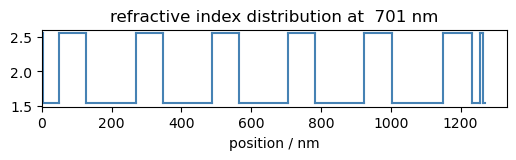

In [3]:
print(design.calculate_loss())
print(design.get_init_ot())
print(design.get_current_ot())
design.film.remove_negative_thickness_layer()
print(design.film.get_layer_number())

import matplotlib.pyplot as plt
plt.plot(losses)

fig, ax = plt.subplots(1, 1)
ax.plot(design.film.get_spec().get_R())

plot_layer_thickness(design.film)
